## Hoori Javadnia


# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [2]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict


2023-06-12 18:10:17.668254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/elyasgoli/anaconda3/lib/python3.10/site-packages/tensorflow/python/framework/dtypes.py:246: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/Users/elyasgoli/anaconda3/lib/python3.10/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp
/Users/elyasgoli/anaconda3/lib/python3.10/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:326: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`. 

In [3]:
nlp = spacy.load('en_core_web_sm')

In [4]:
import matplotlib
import matplotlib.pyplot as plt

In [5]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [6]:
import nltk
nltk.download('brown')
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


[nltk_data] Downloading package brown to /Users/elyasgoli/nltk_data...
[nltk_data]   Package brown is already up-to-date!


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [7]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [8]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

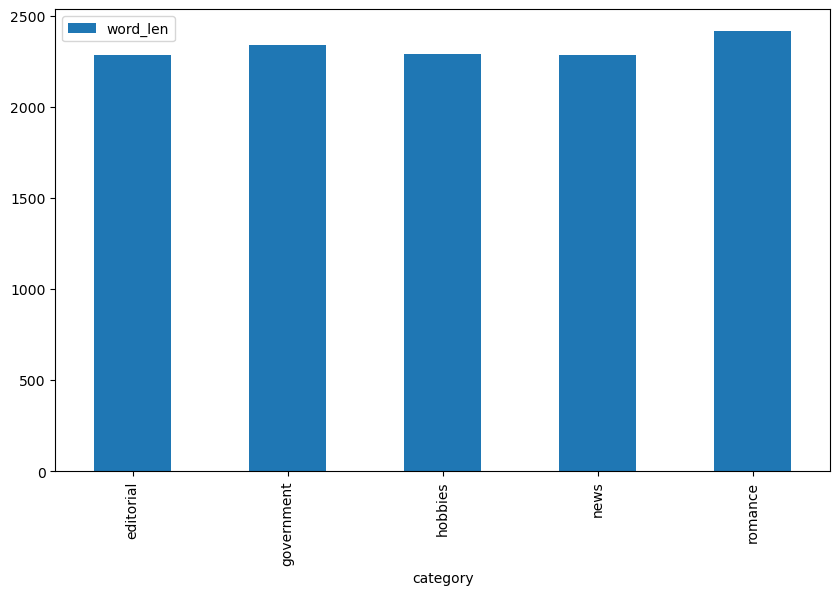

In [9]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [10]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/Users/elyasgoli/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [11]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A:The count_text_vectors dataframe is a matrix with token counts for each document after
removing stop words. Its shape indicates the number of documents (166) and the total tokens
(4,939). The values represent token frequencies in each document.
The tfidf_text_vectors dataframe is a sparse matrix of TF-IDF vectors for each document. It
assigns weights to tokens based on their frequency and document occurrence.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [12]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [13]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [14]:
# Topic index dict 
# (key = topic index) : (value : np.argmax count)
topic_dict = {0 : 0, 1 : 0,
              2 : 0, 3: 0,
              4: 0}
for row in W_text_matrix:
    # Find most similar topic to document
    topic_idx = np.argmax(row)
    # Add 1 count to topic dictionary
    topic_dict[topic_idx] += 1

topic_dict

{0: 32, 1: 41, 2: 65, 3: 18, 4: 10}

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: <!-- Your answer here --> 

A difference between the NMF-generated topic distribution and the actual distribution of documents per topic in the original corpus. For example, NMF categorizes 41 documents as editorial, while there are only 27 in reality, and it assigns 65 documents as government-related, whereas there are only 30 based on the original distribution.



In [15]:
brown_df = pd.DataFrame(columns = ["Editorial", "Government",
                                   "Hobbies", "News", "Romance"])
brown_df.loc[len(brown_df.index)] = [
    27, 30, 36, 44, 29
]
brown_df.loc[len(brown_df.index)] = [
    41, 65, 10, 32, 18
]

brown_df.rename(index = {0:"Original Distribution",
                         1:"NMF Doc. Count"})

,Editorial,Government,Hobbies,News,Romance
Original Distribution,27,30,36,44,29
NMF Doc. Count,41,65,10,32,18


## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [16]:
# LSA Model

lsa_model = TruncatedSVD(n_components = 5, random_state = 7)
W_lsa_matrix = lsa_model.fit_transform(tfidf_text_vectors)
H_lsa_matrix = lsa_model.components_

In [17]:
# Topic index dict 
# (key = topic index) : (value : np.argmax count)
topic_dict = {0 : 0, 1 : 0,
              2 : 0, 3: 0,
              4: 0}
for row in W_lsa_matrix:
    # Find most similar topic to document
    topic_idx = np.argmax(row)
    # Add 1 count to topic dictionary
    topic_dict[topic_idx] += 1

topic_dict

{0: 148, 1: 8, 2: 0, 3: 3, 4: 7}

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: <!-- Your answer here --> 
The document distribution by topic in the LSA model differs greatly from the original distribution in the Brown corpus. The LSA model shows significant variations in the number of documents for each topic compared to the known distributions.



In [19]:
# call display_topics on your model
display_topics(lsa_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.17)
  mr (1.69)
  said (1.06)
  kennedy (0.78)
  khrushchev (0.76)

Topic 03
  mrs (27.04)
  club (6.03)
  game (5.52)
  jr (5.17)
  university (4.72)

Topic 04
  game (4.12)
  league (2.95)
  baseball (2.94)
  ball (2.82)
  team (2.68)


Q: What is your interpretation of the display topics output? 

A: Topic 0 lacks clarity with slowly decreasing contributions. Topic 1 is not well-defined. In
contrast, Topic 2 shows rapid contribution decrease and likely corresponds to News or
Government categories. Topic 4, like Topics 0 and 1, lacks clarity. Topic 3 has a strong focus on
the word &quot;mrs&quot; compared to other words.



## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [20]:
# Fit LDA model
lda_model = LatentDirichletAllocation(n_components = 5, random_state = 7)
W_lda_matrix = lda_model.fit_transform(count_text_vectors)
H_lda_matrix = lda_model.components_

In [21]:
# Call `display_topics` on your fitted model here
display_topics(lda_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  use (0.59)
  water (0.45)
  work (0.38)
  good (0.37)
  high (0.35)

Topic 01
  said (1.41)
  man (0.58)
  old (0.53)
  little (0.49)
  know (0.43)

Topic 02
  said (0.65)
  state (0.61)
  president (0.55)
  tax (0.43)
  city (0.35)

Topic 03
  mrs (1.52)
  mr (0.53)
  clay (0.44)
  work (0.39)
  student (0.38)

Topic 04
  state (1.41)
  states (1.32)
  united (1.23)
  government (0.89)
  shall (0.71)


In [22]:
# Topic index dict 
# (key = topic index) : (value : np.argmax count)
topic_dict = {0 : 0, 1 : 0,
              2 : 0, 3: 0,
              4: 0}
for row in W_lda_matrix:
    # Find most similar topic to document
    topic_idx = np.argmax(row)
    # Add 1 count to topic dictionary
    topic_dict[topic_idx] += 1

topic_dict

{0: 24, 1: 52, 2: 58, 3: 20, 4: 12}

Q: What inference do you draw from the displayed topics for your LDA model? 

A: <!-- Your answer here --> 
The LDA model&#39;s topics show slow decline in contribution values, indicating either vague or lower-
quality topics.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: <!-- Your answer here --> 

The LDA model assigned documents to topics, with two topics closely matching categories in terms
of document counts. One topic contained too many documents compared to any original category.
The LDA model came closest to representing two categories.

In [23]:
lda_display = pyLDAvis.lda_model.prepare(
    lda_model, count_text_vectors,
    count_text_vectorizer,
    sort_topics = False
)

In [24]:
pyLDAvis.save_html(lda_display, 'lda.html')

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: <!-- Your answer here --> 
In above plots, the principal component scatterplot shows that topics 1 and 4 are distinct from the
others, while topics 3 and 5 overlap considerably. Topics 2 and 5 have a slight overlap. The salient
terms bar chart displays the top 30 frequent terms, indicating overall frequency in blue and topic-
specific frequency in red. The rate at which the red portion decreases signifies topic resolution.

In [25]:
pyLDAvis.display(lda_display)